## Differenece From Baseline - stimuli Histogram

In [1]:
import os
import re
from typing import Dict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import mne
import numpy as np
import scipy.stats as sp_stats
from joblib import Parallel, delayed
from NirsLabProject.config.paths import Paths

from NirsLabProject.utils import general_utils as utils
from NirsLabProject.config.consts import *

from NirsLabProject.utils import general_utils as utils
from NirsLabProject.config.consts import *
from NirsLabProject.config.subject import Subject
from NirsLabProject.utils.group_spikes import group_spikes
from NirsLabProject.utils import plotting

In [3]:
subjects = [Subject(d, True) for d in os.listdir(Paths.products_data_dir_path) if d.startswith('p')]
subjects = filter(lambda subj: subj.stimuli_project, subjects)
subjects = filter(lambda subj: os.path.exists(subj.paths.subject_flat_features_path), subjects)
subjects = list(subjects)

In [4]:
baseline_diff = lambda a,b: ((b-a) / max(a,b)) * 100
list_avarage = lambda l: (sum(l) / len(l)) if len(l) > 0 else 0

For every feature (amplitude, spatial spread of multi channel group event) we calculate:
- for every block (stimuli, pause)
    - for every channel the avarage difference from baseline block
histogram of the the avarage diffrences of all the channels of all subjects

Feature name Amplitude
Feature name Spatial Spread
Skipping subject p520
Skipping subject p520
Feature name Event Duration Average
Feature name Spike Width Average
Feature name Spike Angle
Feature name Spike Relative Amplitude
Feature name Spike Relative Width


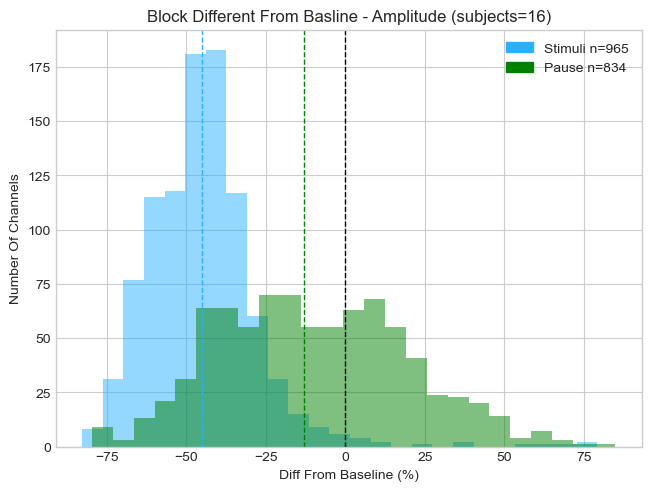

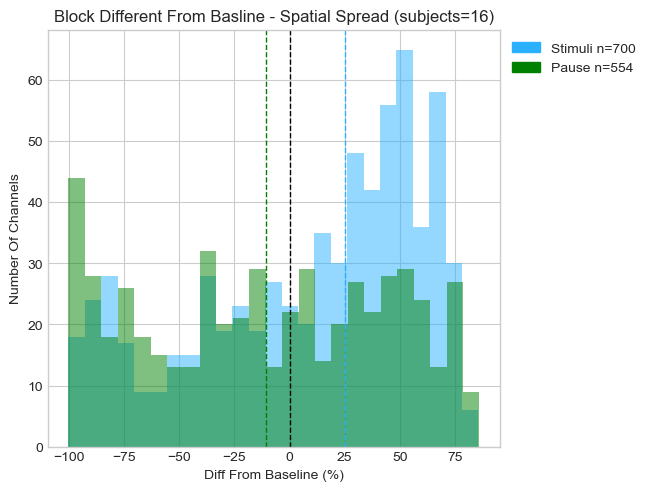

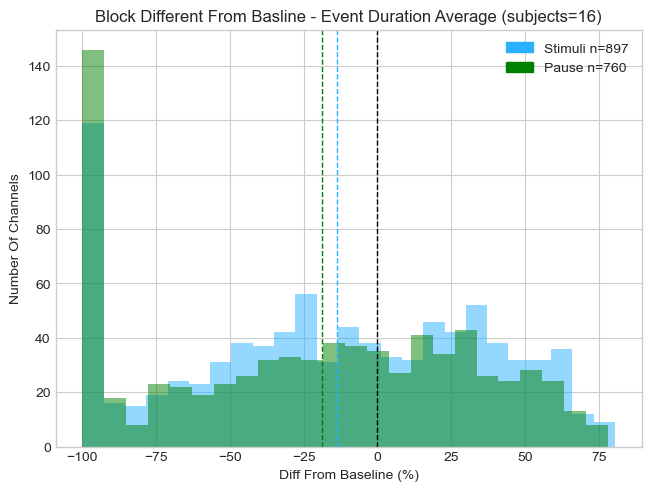

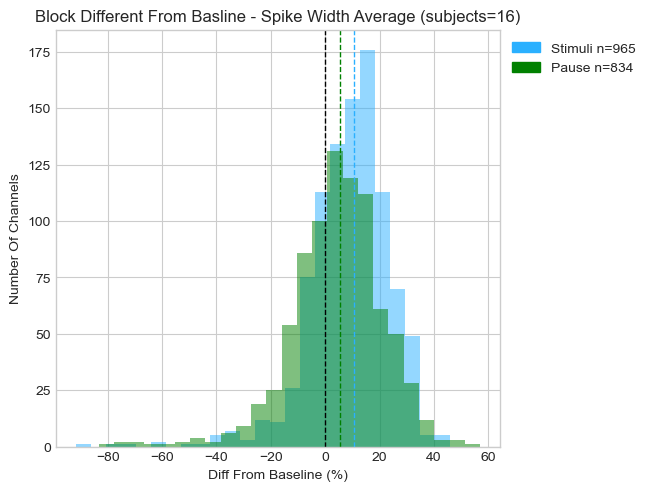

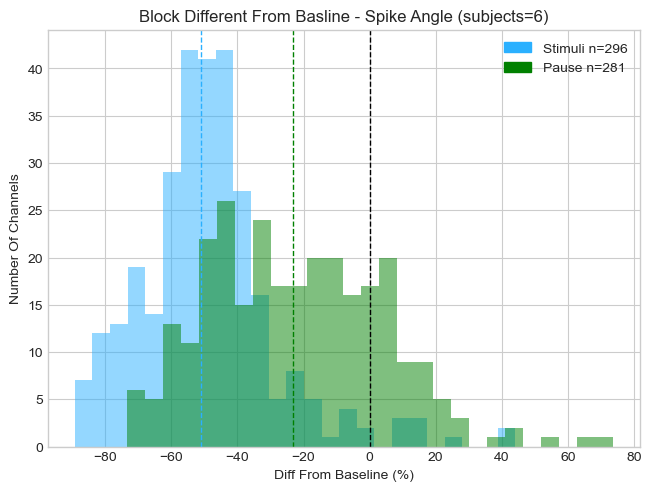

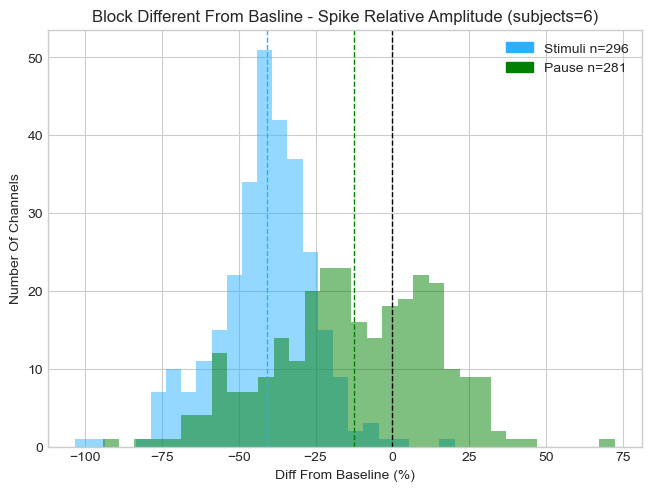

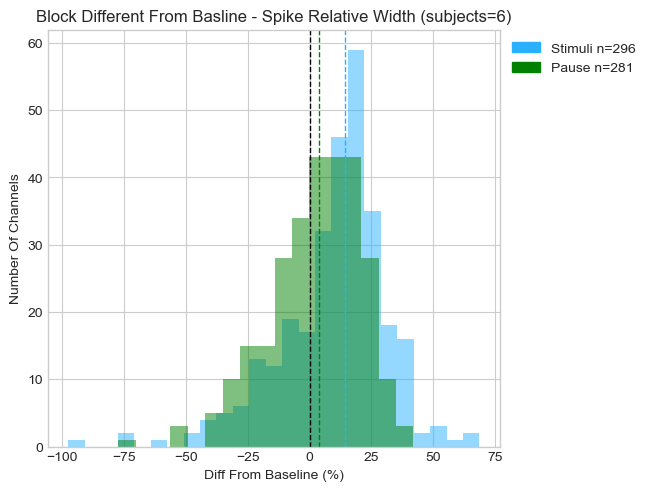

In [6]:


def validate(channels_to_fetures, block_feature):
    count = 0
    for channel, data in channels_to_fetures.items():
        count += len(data)
    assert block_feature.shape[0] == count

features_to_plot = {
    'Amplitude': AMPLITUDE_INDEX,
    'Spatial Spread': GROUP_EVENT_SPATIAL_SPREAD_INDEX,
    'Event Duration Average': GROUP_EVENT_DURATION_INDEX,
    'Spike Width Average': DURATION_INDEX,
    "Spike Angle": ANGLE_INDEX,
    'Spike Relative Amplitude': RELATIVE_SPIKE_AMPLITUDE_INDEX,
    'Spike Relative Width': RELATIVE_SPIKE_DURATION_INDEX
}

subject_s = Subject(STIMULI_PROJECT_INTERSUBJECTS_SUBJECT_NAME, True)
histogrmas_path =  os.path.join(
        subject_s.paths.subject_stimuli_effects_plots_dir_path,
        'histograms'
)
not os.path.exists(histogrmas_path) and  os.makedirs(histogrmas_path)

blocks = ['stimuli', 'pause']
for feature_name, feature_index in features_to_plot.items():
    print(f'Feature name {feature_name}')
    channel_basline_diff = {
        k:[] for k in blocks
    }
    
    n = 0
    for subj in subjects:
        
        subj_features = np.load(subj.paths.subject_flat_features_path)
        if feature_index >= subj_features.shape[1]:
            continue
        
        n += 1
        for block in blocks:
            #  if group feature we don't need more than one representative
            if GROUP_INDEX <= feature_index <= GROUP_EVENT_SPATIAL_SPREAD_INDEX:
                group_ids = subj_features[:, GROUP_INDEX]
                unique_indices = np.unique(group_ids, return_index=True)[1]
                unique_group_subj_features = subj_features[unique_indices]
                if feature_index in [GROUP_EVENT_SPATIAL_SPREAD_INDEX]:
                    unique_group_subj_features = unique_group_subj_features[
                        unique_group_subj_features[:,GROUP_EVENT_SIZE_INDEX] > 2
                    ]  
                before, stim_block, pause_block, _, _ = utils.stimuli_effects(subj, unique_group_subj_features)
            else:
                before, stim_block, pause_block, _, _ = utils.stimuli_effects(subj, subj_features)
            
            if before is None:
                print(f'Skipping subject {subj.name}')
                continue
            
            baseline_mean = np.mean(before[:, feature_index])
            block_to_comapre = stim_block if block == 'stimuli' else pause_block
            channels, _ = np.unique(block_to_comapre[:,CHANNEL_INDEX], return_inverse=True)
            channel_blocks_values = {channel: [] for channel in channels}
            for spike in block_to_comapre:
                channel_blocks_values[spike[CHANNEL_INDEX]].append(spike[feature_index])
            validate(channel_blocks_values, block_to_comapre)

            for channel, features in channel_blocks_values.items():
                channel_basline_diff[block].append(
                    baseline_diff(
                        baseline_mean,
                        list_avarage(features),
                    )
                )
                
    # Plot the histogram
    legend_settings = [
        {
            'color': '#2ab0ff',
            'label': 'Stimuli',
            'n': 0
        },
        {
            'color': 'green',
            'label': 'Pause',
            'n': 0
        }
    ]
    fig = plt.figure(layout='constrained')
    ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
    for i, block in enumerate(channel_basline_diff.keys()):
        if i == 0:
            bin_size = 25
            data = channel_basline_diff[block]
#             lower_threshold = np.percentile(data, 5)
#             upper_threshold = np.percentile(data, 95)
#             data =  [value for value in data if lower_threshold <= value <= upper_threshold]
        else:
            #  old data
            old_bin_size = (max(data) - min(data)) / 25
            data = channel_basline_diff[block]
#             lower_threshold = np.percentile(data, 5)
#             upper_threshold = np.percentile(data, 95)
#             data =  [value for value in data if lower_threshold <= value <= upper_threshold]
            bin_size = int((max(data) - min(data)) / old_bin_size)
            
        hist, edges = np.histogram(data, bins=bin_size)
        median = np.median(data)
        
        legend_settings[i]['n'] = len(data)

        plt.hist(
            data,
            bins=bin_size,
            facecolor = legend_settings[i]['color'],
            edgecolor='None',
            linewidth=0.5,
            alpha = 0.5
        )
        plt.axvline(median, color=legend_settings[i]['color'], linestyle='dashed', linewidth=1)
        plt.style.use('seaborn-whitegrid')
    legend = [
        mpatches.Patch(color=settings['color'], label=f"{settings['label']} n={settings['n']}")
        for settings in legend_settings
    ]
    plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
    ax.legend(handles=legend, bbox_to_anchor=(1, 1))                                                
    title = f'Block Different From Basline - {feature_name}'
    plt.title(f'{title} (subjects={n})')
    plt.xlabel('Diff From Baseline (%)')
    plt.ylabel('Number Of Channels')
    plt.savefig(
        os.path.join(
            histogrmas_path,
            f'{title}.png'
        ),
        dpi=1000
    )
